In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import re
from jupyterthemes import jtplot
from datetime import timedelta, datetime
import calendar
import plotly.express as px
jtplot.style()

In [2]:
def getlogs(server):
    """Get server logs and format for analysis"""
    x = pd.read_csv(f'../data/slurm_wrapper_{server}.log', 
                      sep = ' - ', 
                      engine = 'python', 
                      names = ['DATETIME', 'USER', 'RETRY', 'TIMELAPSE', 'RETURNCODE', 'COMMAND'])
    x['DATETIME'] = pd.to_datetime(x['DATETIME'])
    x['USER'] = x['USER'].str.extract(r'(\d+)')
    x['RETRY'] = x['RETRY'].str.extract('(\d+)').astype('int')
    x['TIMELAPSE'] = x['TIMELAPSE'].str.replace('time ', '').astype('float')
    x['RETURNCODE'] = x['RETURNCODE'].str.extract('(\d+)')
    x['JOBID'] = x['COMMAND'].str.extract(r"'(\d{8})'")
    x['COMMANDTYPE'] = x['COMMAND'].str.extract(r"bin/(s\w+)'")
    x['TESTING'] = (x['COMMANDTYPE'] == 'sbatch') & (x['USER'] == '9204')
    x['UNRESPONSIVE'] = (x['TIMELAPSE'] >= 15) & (x['RETURNCODE'] == '1')
    x['SERVER'] = f'{server}'
    return x

In [3]:
ce5 = getlogs('ce5')
ce6 = getlogs('ce6')

In [4]:
ce = pd.concat([ce5, ce6]).sort_values('DATETIME').reset_index(drop = True)

# Problem 3

Calculate some descriptive statistics about 

(3A) how often the scheduler was unresponsive: 

    * Approximately 10.62% of the time overall
    * ce5 approximately 9.14% of the time
    * ce6 approximately 12.11% of the time

(3B) how long these periods of time were, and 

(3C) create a time series plot of when the scheduler was having difficulties.

## (3A) How often was the scheduler unresponsive?

In [5]:
# Write a function to show count and proportion of value_counts() simultaneously
def ct_prop(df, group):
    a = ce[group].value_counts().reset_index().rename(columns = {'index' : f'{group}', 'UNRESPONSIVE' : 'COUNT'})
    b = ce[group].value_counts(normalize = True).reset_index().rename(columns = {'index' : f'{group}', 'UNRESPONSIVE' : 'PROPORTION'})
    ab = a.merge(b)
    return ab

In [6]:
# Overall scheduler response vs unresponse
print('The scheduler is unresponsive approximately 10.62% of the time.')
ct_prop(ce, 'UNRESPONSIVE')

The scheduler is unresponsive approximately 10.62% of the time.


,UNRESPONSIVE,COUNT,PROPORTION
0,False,8533047,0.893755
1,True,1014366,0.106245


In [7]:
# Counts of response vs unresponse by server
ce.groupby(['SERVER', 'UNRESPONSIVE'])['UNRESPONSIVE'].count()

SERVER  UNRESPONSIVE
ce5     False           4335065
        True             435828
ce6     False           4197982
        True             578538
Name: UNRESPONSIVE, dtype: int64

In [8]:
# Scheduler unresponse by server
print('ce6 tends to be unresponsive significantly more often than ce5 (12.11% vs. 9.14)')
ce.groupby(['SERVER'])['UNRESPONSIVE'].mean()

ce6 tends to be unresponsive significantly more often than ce5 (12.11% vs. 9.14)


SERVER
ce5    0.091351
ce6    0.121121
Name: UNRESPONSIVE, dtype: float64

## Problem 3B: How long were the periods of unresponsiveness?

In [9]:
counter = 0
def unresponsive_grouper(x):
    global counter
    if x == False:
        counter += 1
        entry = np.nan
    else:
        entry = counter
    return entry

In [10]:
ce['UNRESPONSIVEGROUP'] = ce['UNRESPONSIVE'].apply(unresponsive_grouper)

In [11]:
ce.loc[ce['UNRESPONSIVE'] == True].head(50)

,DATETIME,USER,RETRY,TIMELAPSE,RETURNCODE,COMMAND,JOBID,COMMANDTYPE,TESTING,UNRESPONSIVE,SERVER,UNRESPONSIVEGROUP
4396,2020-10-16 11:43:45.753267,9201,0,20.150959,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",NaN,sbatch,False,True,ce5,4396.0
4397,2020-10-16 11:43:45.920205,9201,0,20.218138,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",NaN,sbatch,False,True,ce5,4396.0
4398,2020-10-16 11:43:45.939591,9201,0,20.188296,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",NaN,sbatch,False,True,ce5,4396.0
4399,2020-10-16 11:43:46.119672,9201,0,20.114305,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",NaN,sbatch,False,True,ce5,4396.0
4400,2020-10-16 11:43:46.380161,9202,0,20.092560,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",NaN,sbatch,False,True,ce5,4396.0
4401,2020-10-16 11:43:49.344696,9201,0,20.031806,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",NaN,sbatch,False,True,ce6,4396.0
4414,2020-10-16 11:43:54.936191,9202,0,20.070352,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",NaN,sbatch,False,True,ce5,4408.0
17180,2020-10-16 17:42:39.122099,9202,0,20.328625,1,"command ['/usr/bin/scontrol', 'show', 'job']",NaN,scontrol,False,True,ce6,17173.0
17307,2020-10-16 17:43:27.162054,9201,0,20.462368,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",NaN,sbatch,False,True,ce6,17299.0
17308,2020-10-16 17:43:27.239877,9201,0,20.357604,1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",NaN,sbatch,False,True,ce6,17299.0


In [12]:
unresponsive_intervals = (ce.groupby('UNRESPONSIVEGROUP', as_index = False)
                          ['DATETIME']
                          .apply(lambda x: x.max() - x.min())
                          .rename(columns = {'DATETIME' : 'INTERVALLENGTH'})
                       )
unresponsive_intervals

,UNRESPONSIVEGROUP,INTERVALLENGTH
0,4396.0,0 days 00:00:03.591429
1,4408.0,0 days 00:00:00
2,17173.0,0 days 00:00:00
3,17299.0,0 days 00:00:00.383366
4,17542.0,0 days 00:00:00
...,...,...
87900,8514105.0,0 days 00:00:00
87901,8514106.0,0 days 00:00:00.047851
87902,8514108.0,0 days 00:00:00.107661
87903,8514109.0,0 days 00:00:00.139284


In [13]:
unresponsive_intervals['INTERVALLENGTH'].describe()

count                        87905
mean     0 days 00:00:06.127988967
std      0 days 00:00:39.957379362
min                0 days 00:00:00
25%                0 days 00:00:00
50%         0 days 00:00:00.110372
75%         0 days 00:00:04.698021
max         0 days 03:03:11.213543
Name: INTERVALLENGTH, dtype: object

[(1e-05, 1000.0)]

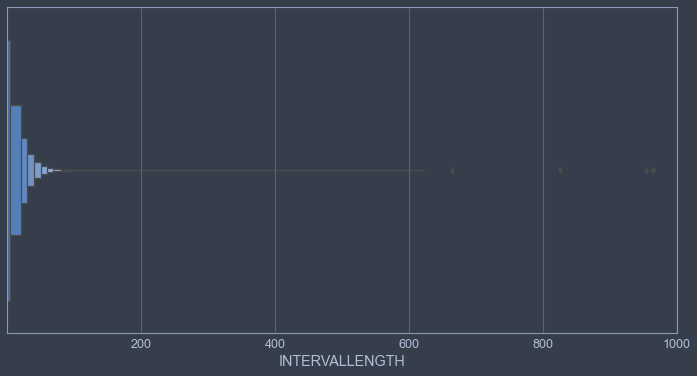

In [14]:
plt.subplots(figsize = (12, 6))
ax = sns.boxenplot(x = unresponsive_intervals['INTERVALLENGTH'].astype('timedelta64[s]'))
ax.set(xlim = (0.00001, 1000))

[None, (1e-05, 1000)]

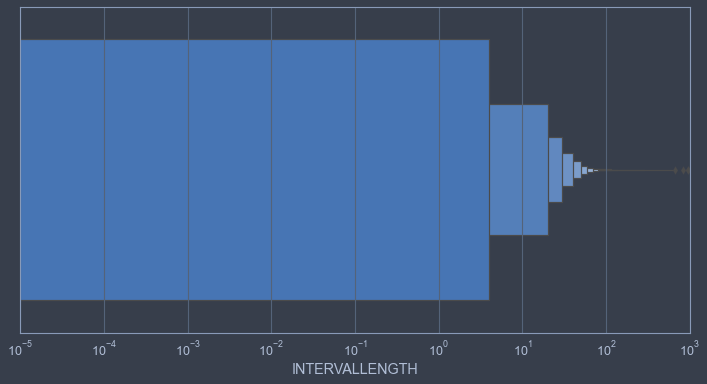

In [15]:
plt.subplots(figsize = (12, 6))
ax2 = sns.boxenplot(x = unresponsive_intervals['INTERVALLENGTH'].astype('timedelta64[s]'))
ax2.set(xscale = 'log', xlim = (0.00001, 1000))

## (3C) Create a time series plot of when the scheduler was having difficulties.

## Problem 4

Finally, combine the time series information from the two datasets together to see 

(4A) how well correlated heavy job-completion load is with the unresponsiveness, and 

(4B) to see if there is some threshold of job completions per hour that generally results in unresponsiveness.

In [16]:
slurm_jobs = pd.read_csv('../data/slurm_jobs.csv')

In [17]:
datetime_cols = ['BEGIN', 'END']
for col in datetime_cols:
    slurm_jobs[col] = pd.to_datetime(slurm_jobs[col])

timedelta_cols = ['REQTIME', 'USEDTIME']
for col in timedelta_cols:
    slurm_jobs[col] = pd.to_timedelta(slurm_jobs[col])

In [18]:
# regex = re.compile(r'((?P<hours>\d+?)h)?((?P<minutes>\d+?)m)?((?P<seconds>\d+?)s)?')

# def parse_time(time_str):
#     parts = regex.match(time_str)
#     if not parts:
#         return
#     parts = parts.groupdict()
#     time_params = {}
#     for name, param in parts.items():
#         if param:
#             time_params[name] = int(param)
#     return timedelta(**time_params)

In [19]:
# def check_unresponsive(x, window = '1h'):
#     cef = ce.loc[(ce['DATETIME'] >= x - parse_time(window))
#                  &
#                  (ce['DATETIME'] <= x)]
#     unresp = cef['UNRESPONSIVE'].any()
#     return unresp

In [20]:
#slurm_jobs['END'].apply(check_unresponsive)

In [21]:
slurm_jobs.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,TIMEOUT,SIGNAL,IN_ARRAY,ARRAYID,ROLL1HR
0,24460577,COMPLETED,2020-10-01 00:05:55,2020-10-01 00:10:15,4096Mc,868.77M,0 days 12:00:00,0 days 00:04:20,1,1,production,0,False,0,False,NaN,1.0
1,24460647,COMPLETED,2020-10-01 00:10:38,2020-10-01 00:12:58,2000Mn,0.09M,2 days 00:00:00,0 days 00:02:20,1,1,sam,0,False,0,False,NaN,2.0
2,24460639,COMPLETED,2020-10-01 00:11:22,2020-10-01 00:13:31,1024Mc,221.10M,0 days 00:30:00,0 days 00:02:09,1,1,production,0,False,0,False,NaN,3.0
3,24460668,COMPLETED,2020-10-01 00:15:16,2020-10-01 00:17:23,2000Mn,0.09M,2 days 00:00:00,0 days 00:02:07,1,1,sam,0,False,0,False,NaN,4.0
4,24460671,COMPLETED,2020-10-01 00:17:08,2020-10-01 00:17:53,1024Mc,636.96M,0 days 00:30:00,0 days 00:00:45,1,1,production,0,False,0,False,NaN,5.0


## (4A) How well correlated is heavy job-completion load with unresponsiveness?

-- Mix in logs (ce) with jobs (slurm_jobs)

    * subset ce into relevant columns; call it c
    * concatenate slurm_jobs and c; call it slurm_c
    
-- Create rolling window to check for unresponsivenss

    * sort and reset index of slurm_c
    * create rolling window to determine whether the scheduler was unresponsive within the hour prior to each job (returning True/False or 1/0). This will allow us to correlate ROLL1HR with unresponsivenss ('ROLL1HRUR')
    * filter out null columns to make slurm_cf
    
-- Make logistic regression model

    * Make the base model with sm.GLM
    * Make the model with ROLL1HR as exog
    * Plot the model
    * Make model with Logit to confirm results and to construct confusion matrix

### Mix in logs (ce) with jobs (slurm_jobs)

In [22]:
c = ce[['DATETIME', 'TESTING', 'UNRESPONSIVE']]
c = c.rename(columns = {'DATETIME' : 'END'})

In [23]:
slurm_c = pd.concat([slurm_jobs, c])

### Create rolling window to check for unresponsivenss

In [24]:
slurm_c = slurm_c.sort_values('END').reset_index(drop = True)

In [25]:
slurm_c['ROLL1HRUR'] = (slurm_c
        .rolling('1h', on = 'END')
        ['UNRESPONSIVE']
        .max()
)

In [26]:
slurm_cf = slurm_c[~slurm_c['JOBID'].isnull()].dropna(subset = ['ROLL1HR', 'ROLL1HRUR'])

### Make logistic regression model: ROLL1HR model shows AIC improvement over base model

In [28]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_cf['ROLL1HRUR'],
                       exog = sm.add_constant(slurm_cf[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_base.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ROLL1HRUR   No. Observations:              7012655
Model:                            GLM   Df Residuals:                  7012654
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.8582e+06
Date:                Wed, 03 Nov 2021   Deviance:                   9.7164e+06
Time:                        23:01:29   Pearson chi2:                 7.01e+06
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0547      0.001     72.428      0.0

In [29]:
logreg_unresponsive_roll = (sm.GLM(endog = slurm_cf['ROLL1HRUR'],
                       exog = sm.add_constant(slurm_cf['ROLL1HR']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ROLL1HRUR   No. Observations:              7012655
Model:                            GLM   Df Residuals:                  7012653
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.7367e+06
Date:                Wed, 03 Nov 2021   Deviance:                   9.4734e+06
Time:                        23:01:46   Pearson chi2:                 7.02e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2717      0.001   -267.214      0.0

### Plot the model: No responsive hours with jobs per hour over 12,934

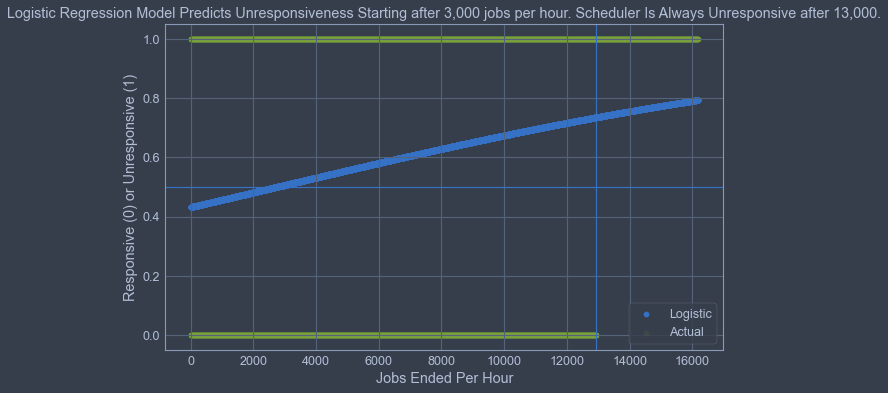

In [54]:
fig, ax = plt.subplots(figsize = (10,6))

x = slurm_cf['ROLL1HR']
y_logistic = 1/(1+np.exp(-(-0.2717 + (0.0001*x))))
plt.scatter(x, y_logistic, label = 'Logistic')

x = slurm_cf['ROLL1HR']
y = slurm_cf['ROLL1HRUR']
plt.scatter(x, y, label = 'Actual', alpha = 0.1)
ax.axhline(0.5)
ax.axvline(slurm_cf.loc[slurm_cf['ROLL1HRUR'] == False, 'ROLL1HR'].max())
plt.legend()
plt.title("Logistic Regression Model Predicts Unresponsiveness Starting after 3,000 jobs per hour. Scheduler Is Always Unresponsive after 13,000.")
plt.ylabel("Responsive (0) or Unresponsive (1)")
plt.xlabel("Jobs Ended Per Hour");

### Confirm the model

In [31]:
model = sm.Logit(slurm_cf['ROLL1HRUR'], sm.add_constant(slurm_cf['ROLL1HR']))
result = model.fit(method = 'newton')
result.params

Optimization terminated successfully.
         Current function value: 0.675453
         Iterations 5


const     -0.271701
ROLL1HR    0.000143
dtype: float64

### Check the model using the confusion matrix. We're better at predicting unresponsiveness than responsiveness, but still not great overall. But, importantly, we get better at predicting unresponsiveness as ROLL1HR increases.

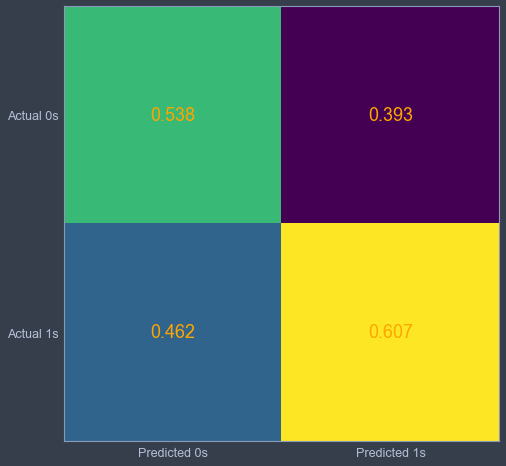

In [49]:
cm = np.round(result.pred_table()/sum(result.pred_table()),3)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='orange', size = 18)
plt.show()